In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels
from quantbullet.linear_product_model.utils import init_betas_by_response_mean

## Single Feature Classification Problem

In [36]:
np.random.seed(42)
n_samples = 1000_000
x1 = np.random.uniform(0, 4, n_samples)
y = ( x1 - 2 ) ** 2 + np.random.normal(0, 1, n_samples) + 10
df = pd.DataFrame({'x1': x1, 'y': y})

In [37]:
x1_trans = FlatRampTransformer(
    knots = [0.5, 1, 2, 3, 3.5],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() )

In [38]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=np.arange(0.2, 4, 0.2))
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )

In [39]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist()}

In [40]:
probs = 1 / (1 + np.exp(-(df['y'] - 16)))
df['binary_y'] = np.random.binomial(1, probs)
print(df['binary_y'].mean())

0.028057


In [41]:
from quantbullet.optimizer import LinearProductClassifierScipy

lpc_scipy = LinearProductClassifierScipy(ftol=1e-8, gtol=1e-8, eps=1e-3)

In [42]:
lpc_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups )

Using initial params: {'x1': array([0.00086681, 0.00040644, 0.00078578, 0.00140893, 0.002059  ,
       0.00268176, 0.003061  ])}
Iter 1: 120524.46458936627
Iter 2: 120394.94039531187
Iter 3: 120328.09485998016
Iter 4: 119893.0870980081
Iter 5: 117957.189122154
Iter 6: 117111.7012294235
Iter 7: 116520.30543006501
Iter 8: 116274.73881632109
Iter 9: 116039.34895955055
Iter 10: 115951.52816295634
Iter 11: 115901.44458243983
Iter 12: 115886.3335595264
Iter 13: 115822.97892018167
Iter 14: 115579.8500813241
Iter 15: 114719.18728830043
Iter 16: 114701.66754688484
Iter 17: 114445.55825893892
Iter 18: 113853.51309851436
Iter 19: 113688.74972542896
Iter 20: 113629.95336176122
Iter 21: 113628.18999167146
Iter 22: 113626.55929473003
Iter 23: 113610.96202819783
Iter 24: 113532.56078047382
Iter 25: 113524.89731755575
Iter 26: 113363.87613065641
Iter 27: 113212.6823861709
Iter 28: 112803.51097255124
Iter 29: 112525.88839216359
Iter 30: 112305.62830375132
Iter 31: 112287.9349229647
Iter 32: 112286.7554

In [43]:
df['clf_scipy_pred_prob'] = lpc_scipy.predict(train_df)

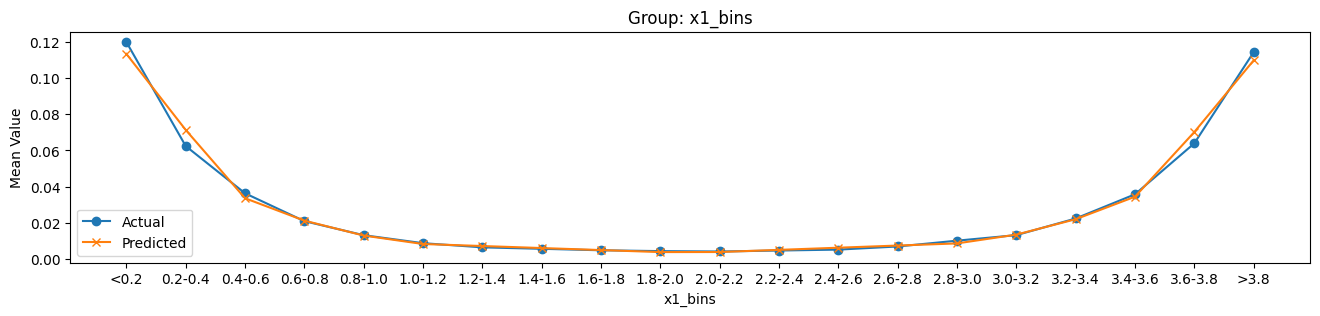

In [44]:
for group in ['x1_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_scipy_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_scipy_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Use $X\beta$ to fit $y$ with Log Loss Minimization

In [70]:
import numpy as np
from scipy.optimize import minimize

def clipped_ce_and_grad(beta, X, y, eps=1e-6, l2=0.0):
    """
    Cross-entropy on p = clip(X @ beta, eps, 1-eps).
    Returns (loss, grad) with grad matching the piecewise derivative described.
    """
    z = X @ beta                          # (n,)
    p = np.clip(z, eps, 1.0 - eps)        # (n,)

    # ----- Loss -----
    # CE(p,y) = -[ y log p + (1-y) log(1-p) ]
    ce = - (y * np.log(p) + (1 - y) * np.log(1 - p)).sum()
    if l2:
        ce += 0.5 * l2 * np.dot(beta, beta)

    # ----- Gradient wrt beta -----
    # dCE/dp = (p - y) / (p(1-p))
    dCE_dp = (p - y) / (p * (1.0 - p))

    # dp/dz = 1 on the interior, 0 when clipped
    interior = (z > eps) & (z < 1.0 - eps)
    dL_dz = np.zeros_like(z)
    dL_dz[interior] = dCE_dp[interior]  # chain rule: dL/dz = dCE/dp * dp/dz

    grad = X.T @ dL_dz
    if l2:
        grad += l2 * beta

    return ce, grad

def fit_clipped_ce(X, y, beta0=None, eps=1e-6, l2=0.0, tol=1e-8, maxiter=10_000):
    n_features = X.shape[1]
    if beta0 is None:
        beta0 = init_betas_by_response_mean(X, np.mean(y))
    elif np.isscalar(beta0):
        beta0 = np.full(n_features, beta0)
    else:
        beta0 = np.asarray(beta0, dtype=float)
        if beta0.shape != (n_features,):
            raise ValueError(f"beta0 must be a scalar or a 1D array of shape ({n_features},)")
    obj = lambda b: clipped_ce_and_grad(b, X, y, eps=eps, l2=l2)
    res = minimize(obj, beta0, method="L-BFGS-B", jac=True, tol=tol,
                   options={"maxiter": maxiter})
    return res.x, res

In [77]:
beta, res = fit_clipped_ce(train_df.values, df['binary_y'].values, eps=1e-3)

In [78]:
df['ce_pred_prob'] = np.clip(train_df.values @ beta, 1e-3, 1 - 1e-3)

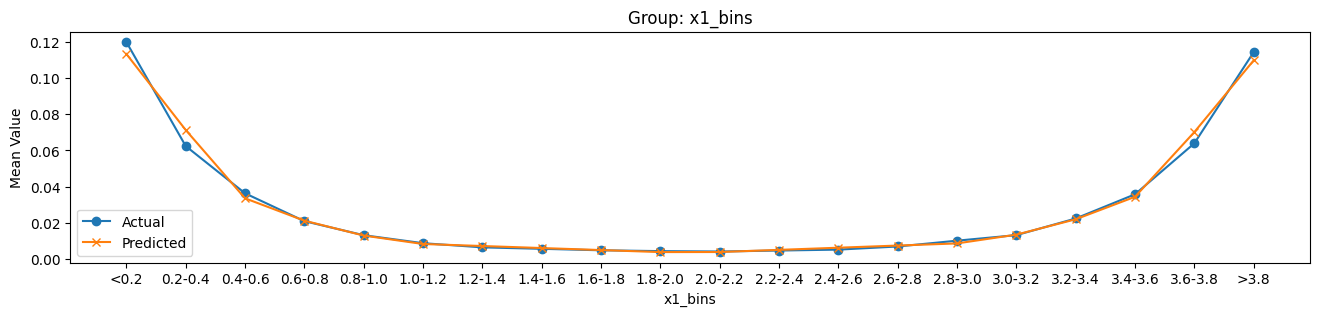

In [79]:
for group in ['x1_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'ce_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['ce_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## BCD Optimization

In [15]:
from quantbullet.optimizer import LinearProductClassifierBCD

lpc_bcd = LinearProductClassifierBCD()

In [16]:
lpc_bcd.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=5 )

Using initial params: {'x1': array([0.00087505, 0.00041018, 0.00079288, 0.00142165, 0.00207786,
       0.00270674, 0.0030895 ])}
Iteration 1/5, Loss: 0.1965
Iteration 2/5, Loss: 6.7122
Iteration 3/5, Loss: 0.1965
Iteration 4/5, Loss: 6.7122
Iteration 5/5, Loss: 0.1965


In [17]:
df['clf_bcd_pred_prob'] = lpc_bcd.predict(train_df)

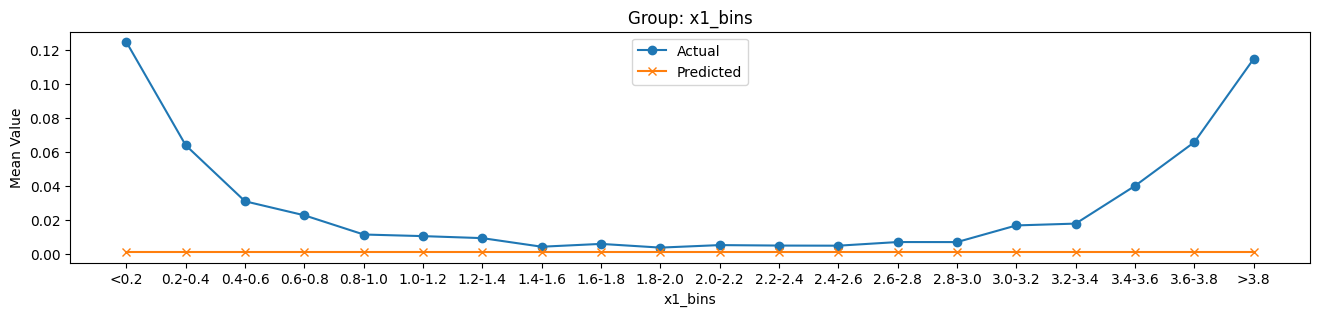

In [18]:
for group in ['x1_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_bcd_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_bcd_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()